In [1]:
import os
import cv2
import math
import time
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from math import sqrt
from tqdm import tqdm
from pathlib import Path
import torch.optim as optim
import torch.optim as optim
from torchinfo import summary
from datetime import timedelta
from functools import lru_cache
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, confusion_matrix, classification_report
)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
dataset = Path(r"/kaggle/input/")
covid_19 = dataset / "covid19-radiography-database" / "COVID-19_Radiography_Dataset"
chest_xray = dataset / "chest-xray-pneumonia" / "chest_xray"
tb_chest = dataset / "tuberculosis-tb-chest-xray-dataset" / "TB_Chest_Radiography_Database"

In [4]:
class_mapping = defaultdict(list)

def append_file_names(directory, cls_name):
    """
    Append file names from a given directory to the corresponding class in the class_mapping dictionary.

    Args:
        directory (str): Directory path.
        cls_name (str): Name of the class.
    """
    for f_name in os.listdir(directory):
        if f_name.endswith((".jpeg", ".png")):
            class_mapping[cls_name].append(os.path.join(directory, f_name))

In [5]:
for covid19_class in [entry.name for entry in os.scandir(covid_19) if entry.is_dir()]:
    append_file_names(covid_19 / f"{covid19_class}" / 'images', f"{covid19_class}")

In [6]:
pneumonia_dirs = [chest_xray / "train" / "PNEUMONIA",
                  chest_xray / "test" / "PNEUMONIA",
                  chest_xray / "val" / "PNEUMONIA"]
for source_dir in pneumonia_dirs:
    for filename in os.listdir(source_dir):
        if filename.endswith(".jpeg"):
            if "bacteria" in filename:
                class_mapping["Bacterial Pneumonia"].append(os.path.join(source_dir, filename))

In [7]:
append_file_names(tb_chest / "Tuberculosis", "Tuberculosis")

In [8]:
class_names = list(class_mapping.keys())
image_paths = []
labels = []

for class_name, file_paths in class_mapping.items():
    for file_path in tqdm(file_paths, desc=f"Processing {class_name}"):
        image_paths.append(file_path)
        labels.append(class_name)

Processing Tuberculosis: 100%|██████████| 700/700 [00:00<00:00, 3160401.29it/s]


In [9]:
def is_black_and_white(image):
    """
    Check if the given image is black and white (grayscale).

    Parameters:
        image (PIL.Image.Image): The image object to check.

    Returns:
        bool: True if the image is black and white, False otherwise.
    """
    return image.mode == 'L'

In [10]:
from concurrent.futures import ThreadPoolExecutor
from PIL import Image

In [11]:
def process_image(image_path, label):
    """
    Process a single image and return the color type.

    Parameters:
        image_path (str): File path of the image.
        label: Class label of the image.

    Returns:
        tuple: A tuple containing the label and color type ('Black & White' or 'Colored').
    """
    with Image.open(image_path) as image:
        color_type = 'Black & White' if is_black_and_white(image) else 'Colored'
    return label, color_type

def count_images_per_class(image_paths, labels):
    """
    Count the number of black and white and colored images per class.

    Parameters:
        image_paths (list): List of file paths of the images.
        labels (list): List of corresponding class labels.

    Returns:
        pandas.DataFrame: DataFrame containing the counts per class in tabular format.
    """
    data = defaultdict(lambda: {'Black & White': 0, 'Colored': 0})

    with ThreadPoolExecutor() as executor:
        processed_results = list(tqdm(executor.map(process_image, image_paths, labels), total=len(image_paths), desc="Processing images"))

    for label, color_type in processed_results:
        data[label][color_type] += 1

    df = pd.DataFrame(data).transpose().reset_index()
    df = df.rename(columns={'index': 'Class'})
    return df

result_df = count_images_per_class(image_paths, labels)
print(result_df)

Processing images: 100%|██████████| 24645/24645 [00:20<00:00, 1178.56it/s]

                 Class  Black & White  Colored
0               Normal          10192        0
1         Lung_Opacity           6012        0
2      Viral Pneumonia           1205      140
3                COVID           3616        0
4  Bacterial Pneumonia           2637      143
5         Tuberculosis            308      392


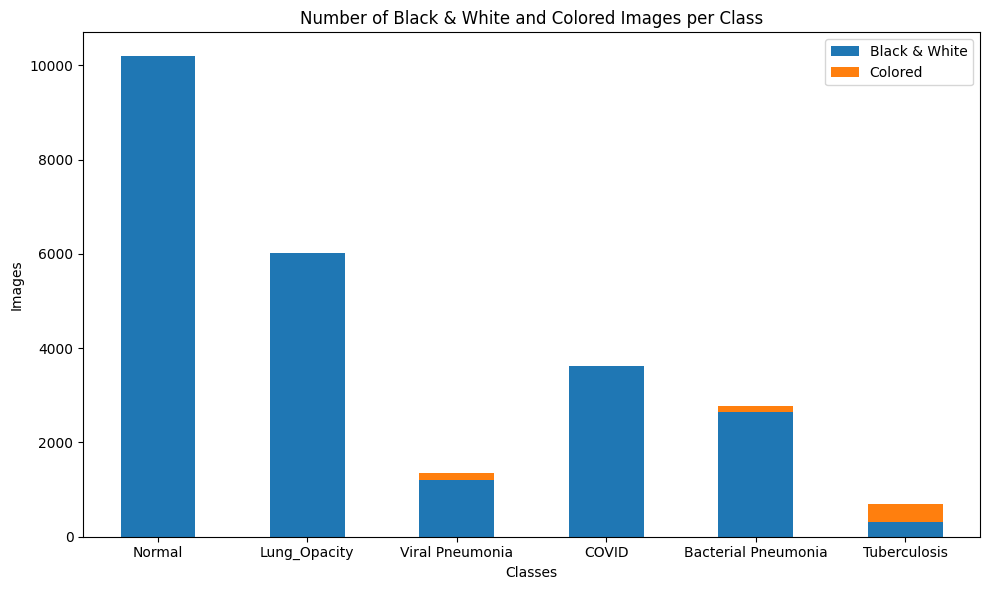

In [12]:
def visualize_images_per_class(result_df, class_column='Class', bw_column='Black & White', colored_column='Colored'):
    """
    Visualize the number of black and white images and colored images per class.

    Parameters:
        result_df (pandas.DataFrame): DataFrame containing the counts per class.
        class_column (str): Name of the column containing the class labels.
        bw_column (str): Name of the column containing the count of black and white images.
        colored_column (str): Name of the column containing the count of colored images.

    Returns:
        None
    """
    result_df.set_index(class_column, inplace=True)

    ax = result_df.plot(kind='bar', stacked=True, figsize=(10, 6), rot=0)
    ax.set_xlabel('Classes')
    ax.set_ylabel('Images')
    ax.set_title('Number of Black & White and Colored Images per Class')
    ax.legend(["Black & White", "Colored"])

    plt.tight_layout()
    plt.show()

visualize_images_per_class(result_df)

Loading and displaying images: 100%|██████████| 6/6 [00:00<00:00, 223.24it/s]


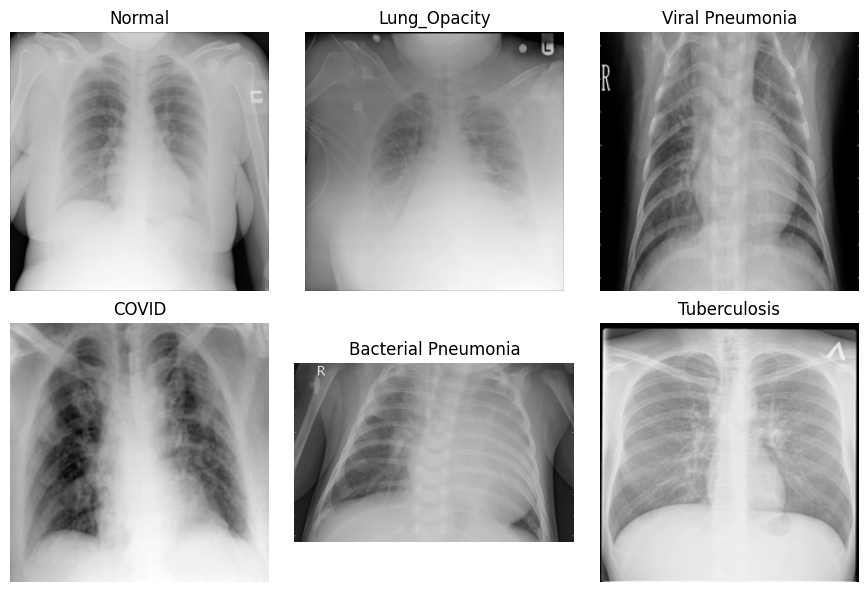

In [13]:
def group_images_by_class(image_paths, labels):
    """
    Group image paths by class label.

    Parameters:
        image_paths (list): List of file paths of the images.
        labels (list): List of corresponding class labels.

    Returns:
        dict: A dictionary where the keys are class labels, and the values are lists of image paths for each class.
    """
    class_to_images = {}
    for img_path, label in zip(image_paths, labels):
        if label not in class_to_images:
            class_to_images[label] = []
        class_to_images[label].append(img_path)
    return class_to_images

def display_images_per_class(image_paths, labels):
    class_to_images = group_images_by_class(image_paths, labels)
    num_classes = len(class_to_images)

    num_rows, num_cols = 1, num_classes
    if num_classes == 4:
        num_rows, num_cols = 2, 2
    elif num_classes == 6:
        num_rows, num_cols = 2, 3

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 3 * num_rows))

    with tqdm(total=num_classes, desc="Loading and displaying images") as pbar:
        for i, (class_label, image_paths_for_class) in enumerate(class_to_images.items()):
            selected_image_path = random.choice(image_paths_for_class)
            try:
                selected_image = Image.open(selected_image_path)
                ax = axs[i // num_cols, i % num_cols]
                ax.imshow(selected_image, cmap='gray')
                ax.set_title(class_label)
                ax.axis('off')
            except Exception as e:
                print(f"Error loading image: {selected_image_path}")
                print(e)

            pbar.update(1)

    plt.tight_layout()
    plt.show()

display_images_per_class(image_paths, labels)

Displaying Images: 100%|██████████| 6/6 [00:17<00:00,  2.99s/it]


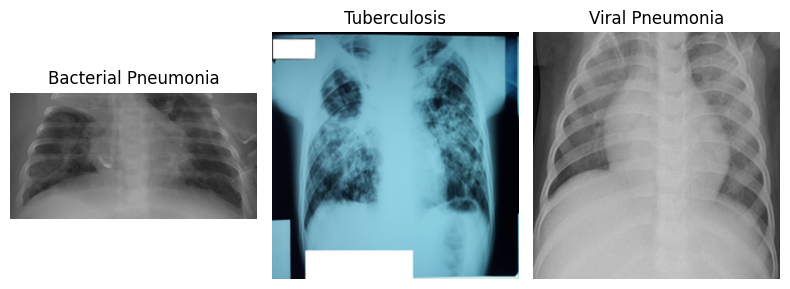

In [14]:
@lru_cache(maxsize=100)
def load_colored_image(image_path):
    """
    Load an image using Pillow and check if it is a colored image (not grayscale).

    Parameters:
        image_path (str): The path to the image file.

    Returns:
        numpy.ndarray or None: The loaded colored image as a NumPy array, or None if grayscale.
    """
    try:
        img = Image.open(image_path)
        if not is_black_and_white(img):
            return np.array(img)
    except (IOError, OSError) as e:
        raise Exception(f"Error loading image '{image_path}': {e}")
    return None

def display_colored_images(image_paths, labels, num_images_per_class=1):
    """
    Randomly display colored images for each class.

    Parameters:
        image_paths (list): List of file paths of the images.
        labels (list): List of corresponding class labels.
        num_images_per_class (int): Number of images to display per class.

    Returns:
        None
    """
    plt.figure(figsize=(8, 6))
    displayed_classes = 0
    unique_labels = set(labels)

    shuffled_labels = list(unique_labels)
    random.shuffle(shuffled_labels)

    for class_label in tqdm(shuffled_labels, desc="Displaying Images"):
        image_paths_for_class = [img_path for img_path, lbl in zip(image_paths, labels) if lbl == class_label]
        colored_images_for_class = [img_path for img_path in image_paths_for_class if load_colored_image(img_path) is not None]

        if len(colored_images_for_class) == 0:
            continue

        num_images_to_display = min(len(colored_images_for_class), num_images_per_class)

        for i in range(num_images_to_display):
            selected_image_path = random.choice(colored_images_for_class)
            selected_image = load_colored_image(selected_image_path)

            displayed_classes += 1
            plt.subplot(2, 3, displayed_classes)
            plt.imshow(selected_image)
            plt.title(f"{class_label}")
            plt.axis('off')

            if displayed_classes == 6:
                break

        if displayed_classes == 6:
            break

    plt.tight_layout()
    plt.show()

display_colored_images(image_paths, labels, num_images_per_class=1)

In [15]:
# Encode the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
classes = label_encoder.classes_
num_classes = len(classes)

# First: split off the test set (10% of the total)
remaining_paths, test_paths, remaining_labels, test_labels = train_test_split(
    image_paths,
    labels_encoded,
    test_size=0.1,
    random_state=42,
    stratify=labels_encoded
)

# Second: from the remaining 90%, split off the validation set.
# To have validation = 10% of the total, we use test_size = 0.1 / 0.9 ≈ 0.1111 here.
train_paths, val_paths, train_labels, val_labels = train_test_split(
    remaining_paths,
    remaining_labels,
    test_size=0.1111,
    random_state=42,
    stratify=remaining_labels
)

# Calculate total counts and percentages
total_samples = len(labels_encoded)
total_train_samples = len(train_paths)
total_val_samples = len(val_paths)
total_test_samples = len(test_paths)

train_percentage = (total_train_samples / total_samples) * 100
val_percentage = (total_val_samples / total_samples) * 100
test_percentage = (total_test_samples / total_samples) * 100

# Compute class distribution counts for each split
train_counts = pd.Series(train_labels).value_counts().sort_index()
val_counts = pd.Series(val_labels).value_counts().sort_index()
test_counts = pd.Series(test_labels).value_counts().sort_index()

# Create DataFrames for reporting (assuming 'class_names' is defined)
train_df = pd.DataFrame({'Train Samples': train_counts})
val_df = pd.DataFrame({'Validation Samples': val_counts})
test_df = pd.DataFrame({'Test Samples': test_counts})
train_df.index = val_df.index = test_df.index = class_names

# Print summary information
print("Total Train Samples:", total_train_samples)
print("Total Validation Samples:", total_val_samples)
print("Total Test Samples:", total_test_samples)
print("\nPercentage of Split:")
print("Train: {:.2f}%".format(train_percentage))
print("Validation: {:.2f}%".format(val_percentage))
print("Test: {:.2f}%".format(test_percentage))
print("\nClass Distribution:")
result_df = pd.concat([train_df, val_df, test_df], axis=1)
print(result_df)

Total Train Samples: 19715
Total Validation Samples: 2465
Total Test Samples: 2465

Percentage of Split:
Train: 80.00%
Validation: 10.00%
Test: 10.00%

Class Distribution:
                     Train Samples  Validation Samples  Test Samples
Normal                        2224                 278           278
Lung_Opacity                  2892                 362           362
Viral Pneumonia               4810                 601           601
COVID                         8154                1019          1019
Bacterial Pneumonia            560                  70            70
Tuberculosis                  1075                 135           135


In [16]:
class ImageDataset(Dataset):
    def __init__(self, img_paths, img_labels, transform=None):
        """
        Custom Dataset class to load and preprocess images.

        Args:
            img_paths (list): List of image file paths.
            img_labels (list): List of corresponding image labels.
            transform (callable, optional): Transform to apply to images. Defaults to None.
        """
        self.img_paths = img_paths
        self.img_labels = img_labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img = cv2.imread(str(self.img_paths[index]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        pil_img = Image.fromarray(img)
        
        transformed_img = self.transform(pil_img)

        label = self.img_labels[index]
        return transformed_img, label

In [17]:
BATCH_SIZE = 16

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = ImageDataset(train_paths, train_labels, transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

val_dataset = ImageDataset(val_paths, val_labels, transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

test_dataset = ImageDataset(test_paths, test_labels, transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

train_steps = len(train_loader)
val_steps = len(val_loader)
test_steps = len(test_loader)

In [18]:
MSCViT_CONFIGS = {
    "MSCViT-T": {
        "stem_channels": 16,
        "stages": [
            {"C": 32,  "P": 3, "R": 4},
            {"C": 64,  "P": 3, "R": 3},
            {"C": 128, "P": 5, "R": 2},
            {"C": 256, "P": 5, "R": 1},
        ],
    },
    "MSCViT-XS": {
        "stem_channels": 24,
        "stages": [
            {"C": 48,  "P": 3, "R": 4},
            {"C": 96,  "P": 3, "R": 3},
            {"C": 192, "P": 5, "R": 2},
            {"C": 384, "P": 5, "R": 1},
        ],
    },
    "MSCViT-S": {
        "stem_channels": 32,
        "stages": [
            {"C": 64,  "P": 3, "R": 4},
            {"C": 128, "P": 3, "R": 3},
            {"C": 256, "P": 5, "R": 2},
            {"C": 512, "P": 5, "R": 1},
        ],
    },
}
import torch
import torch.nn as nn

class ConvStem(nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.stem = nn.Sequential(
            # First conv: downsample
            nn.Conv2d(3, out_channels, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            # Repeat conv (×2) with stride = 1
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.stem(x)

class DWConv(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dw = nn.Conv2d(dim, dim, 3, padding=1, groups=dim, bias=False)
        self.pw = nn.Conv2d(dim, dim, 1, bias=False)
        self.bn = nn.BatchNorm2d(dim)
        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.act(self.bn(self.pw(self.dw(x))))

class LFE(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = DWConv(dim)

    def forward(self, x):
        return self.conv(x)

class ChannelMixer(nn.Module):
    def __init__(self, dim, expansion=2):
        super().__init__()
        hidden = dim * expansion
        self.fc1 = nn.Conv2d(dim, hidden, 1, bias=False)
        self.act = nn.GELU()
        self.fc2 = nn.Conv2d(hidden, dim, 1, bias=False)
        self.bn = nn.BatchNorm2d(dim)

    def forward(self, x):
        return self.bn(self.fc2(self.act(self.fc1(x))))

class MSCBlock(nn.Module):
    def __init__(self, dim, attn_depth):
        super().__init__()

        self.lfe = LFE(dim)

        self.mixers = nn.ModuleList([
            ChannelMixer(dim)
            for _ in range(attn_depth)
        ])

    def forward(self, x):
        x = x + self.lfe(x)
        for m in self.mixers:
            x = x + m(x)
        return x

class Stage(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, attn_depth):
        super().__init__()

        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.blocks = nn.ModuleList([
            MSCBlock(out_channels, attn_depth)
            for _ in range(num_blocks)
        ])

    def forward(self, x):
        x = self.downsample(x)
        for blk in self.blocks:
            x = blk(x)
        return x
class MSCViT(nn.Module):
    def __init__(self, variant="MSCViT-T", num_classes=1000, global_pool="avg"):
        super().__init__()

        cfg = MSCViT_CONFIGS[variant]
        self.__class__.__name__ = variant

        self.stem = ConvStem(cfg["stem_channels"])

        in_ch = cfg["stem_channels"]
        self.stages = nn.ModuleList()

        for s in cfg["stages"]:
            self.stages.append(
                Stage(in_ch, s["C"], s["P"], s["R"])
            )
            in_ch = s["C"]

        self.head = nn.Linear(in_ch, num_classes) if num_classes > 0 else nn.Identity()
        self.global_pool = global_pool

    def forward(self, x):
        x = self.stem(x)
        for stage in self.stages:
            x = stage(x)

        x = x.mean((2, 3)) if self.global_pool == "avg" else x.amax((2, 3))
        return self.head(x)
from torchinfo import summary
import torch

image_size = 224           # Standard starting resolution
patch_size = 16            # Balanced for detail vs. compute
in_channels = 3            # Colored images
num_classes = 6            # Four-class classification task

# Medical imaging / Kaggle dataset
model = MSCViT("MSCViT-T", num_classes=6)
model.to(device)

summary(
    model,
    input_size=(1, 3, 224, 224),
    col_names=("input_size", "output_size", "num_params"),
)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #
MSCViT-T                                                [1, 3, 224, 224]          [1, 6]                    --
├─ConvStem: 1-1                                         [1, 3, 224, 224]          [1, 16, 112, 112]         --
│    └─Sequential: 2-1                                  [1, 3, 224, 224]          [1, 16, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224]          [1, 16, 112, 112]         432
│    │    └─BatchNorm2d: 3-2                            [1, 16, 112, 112]         [1, 16, 112, 112]         32
│    │    └─ReLU: 3-3                                   [1, 16, 112, 112]         [1, 16, 112, 112]         --
│    │    └─Conv2d: 3-4                                 [1, 16, 112, 112]         [1, 16, 112, 112]         2,304
│    │    └─BatchNorm2d: 3-5                            [1, 16, 112, 112]         [1, 16, 112, 112]    

In [19]:
def custom_metrics(y_pred, y_true, loss):
    """
    Calculate custom evaluation metrics for multiclass classification.

    Args:
        y_pred (Tensor): Predicted probabilities for each class.
        y_true (Tensor): True labels.
        loss (float): Loss value.

    Returns:
        dict: Dictionary containing computed metrics.
    """
    y_pred_classes = torch.argmax(y_pred, dim=1)

    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()
    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)

    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted')

    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)
    
    tn = cm[0, 0]
    fp = cm[0, 1:].sum()
    fn = cm[1:, 0].sum()
    tp = cm[1:, 1:].sum()

    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)

    num_classes = y_pred.shape[1]
    auc_scores = []

    for class_idx in range(num_classes):
        class_y_true = (y_true_numpy == class_idx).astype(np.float32)
        class_y_pred = y_pred[:, class_idx].cpu().numpy()
        auc_score = roc_auc_score(class_y_true, class_y_pred)
        auc_scores.append(auc_score)

    auc_avg = np.mean(auc_scores)

    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }

    return metrics

In [20]:
# Hyperparameters
num_epochs       = 25
initial_lr       = 1e-4
decay_start_epoch = 10
decay_factor     = 0.97

# Criterion, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# Scheduler policy: 1.0 until epoch 11, then 0.98^(epoch - 11)
lr_lambda = lambda epoch: 1.0 if epoch < decay_start_epoch else decay_factor ** (epoch - decay_start_epoch)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

In [21]:
# Metrics initialization
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {metric_name: [] for metric_name in metric_names}
val_metrics_history = {metric_name: [] for metric_name in metric_names}

total_training_time = 0.0
total_validation_time = 0.0

for epoch in range(num_epochs):
    start_time = time.time()
    
    model.train()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Training Model - Epoch [{epoch + 1}/{num_epochs}]")):
        data = data.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())
    
    end_time = time.time()
    epoch_training_time = end_time - start_time
    total_training_time += epoch_training_time
    
    average_loss = total_loss / len(train_loader)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    train_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)
    training_metrics_line = "Metrics - "
    for metric_name, metric_value in train_metrics.items():
        if metric_name == 'auc':
            training_metrics_line += f"{metric_name}: {metric_value:.4f}"
        else:
            training_metrics_line += f"{metric_name}: {metric_value:.4f}, "
    print(training_metrics_line)
    
    for metric_name in metric_names:
        train_metrics_history[metric_name].append(train_metrics[metric_name])
    
    # Validation loop
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    start_time = time.time()
    
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(val_loader, desc="Validating Model: ")):
            data = data.to(device)
            targets = targets.to(device)
            
            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
            all_predictions.extend(outputs.detach().cpu().numpy())
            all_targets.extend(targets.detach().cpu().numpy())
    
    end_time = time.time()
    epoch_validation_time = end_time - start_time
    total_validation_time += epoch_validation_time
    
    average_loss = total_loss / len(val_loader)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    val_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)
    validation_metrics_line = "Metrics - "
    for metric_name, metric_value in val_metrics.items():
        if metric_name == 'auc':
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}"
        else:
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}, "
    print(validation_metrics_line)
    
    for metric_name in metric_names:
        val_metrics_history[metric_name].append(val_metrics[metric_name])
    
    # Step the scheduler to decay the learning rate by 0.995
    scheduler.step()

print(f"Total Training Time: {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")

avg_training_time_per_epoch = total_training_time / num_epochs
avg_validation_time_per_epoch = total_validation_time / num_epochs
print(f"Average Training Time per Epoch: {str(timedelta(seconds=avg_training_time_per_epoch))}")
print(f"Average Validation Time per Epoch: {str(timedelta(seconds=avg_validation_time_per_epoch))}")

Training Model - Epoch [1/25]: 100%|██████████| 1233/1233 [01:14<00:00, 16.51it/s]


Metrics - loss: 0.6900, accuracy: 0.7395, precision: 0.7358, recall: 0.7395, f1_score: 0.7352, specificity: 0.7900, sensitivity: 0.9614, mcc: 0.6399, auc: 0.8977


Validating Model: 100%|██████████| 155/155 [00:08<00:00, 17.68it/s]


Metrics - loss: 0.6142, accuracy: 0.7716, precision: 0.8048, recall: 0.7716, f1_score: 0.7660, specificity: 0.6619, sensitivity: 0.9877, mcc: 0.6901, auc: 0.9212


Training Model - Epoch [2/25]: 100%|██████████| 1233/1233 [01:14<00:00, 16.55it/s]


Metrics - loss: 0.4522, accuracy: 0.8276, precision: 0.8262, recall: 0.8276, f1_score: 0.8260, specificity: 0.8440, sensitivity: 0.9741, mcc: 0.7629, auc: 0.9408


Validating Model: 100%|██████████| 155/155 [00:08<00:00, 17.26it/s]


Metrics - loss: 0.3917, accuracy: 0.8548, precision: 0.8554, recall: 0.8548, f1_score: 0.8544, specificity: 0.8417, sensitivity: 0.9753, mcc: 0.8006, auc: 0.9547


Training Model - Epoch [3/25]: 100%|██████████| 1233/1233 [01:15<00:00, 16.36it/s]


Metrics - loss: 0.3634, accuracy: 0.8644, precision: 0.8638, recall: 0.8644, f1_score: 0.8636, specificity: 0.8719, sensitivity: 0.9816, mcc: 0.8140, auc: 0.9516


Validating Model: 100%|██████████| 155/155 [00:08<00:00, 17.68it/s]


Metrics - loss: 0.3336, accuracy: 0.8791, precision: 0.8798, recall: 0.8791, f1_score: 0.8784, specificity: 0.8957, sensitivity: 0.9803, mcc: 0.8340, auc: 0.9494


Training Model - Epoch [4/25]: 100%|██████████| 1233/1233 [01:14<00:00, 16.55it/s]


Metrics - loss: 0.3168, accuracy: 0.8819, precision: 0.8814, recall: 0.8819, f1_score: 0.8815, specificity: 0.8889, sensitivity: 0.9847, mcc: 0.8381, auc: 0.9588


Validating Model: 100%|██████████| 155/155 [00:08<00:00, 18.11it/s]


Metrics - loss: 0.3482, accuracy: 0.8645, precision: 0.8856, recall: 0.8645, f1_score: 0.8651, specificity: 0.5971, sensitivity: 0.9959, mcc: 0.8179, auc: 0.9641


Training Model - Epoch [5/25]: 100%|██████████| 1233/1233 [01:14<00:00, 16.61it/s]


Metrics - loss: 0.2714, accuracy: 0.8991, precision: 0.8987, recall: 0.8991, f1_score: 0.8987, specificity: 0.9065, sensitivity: 0.9872, mcc: 0.8617, auc: 0.9655


Validating Model: 100%|██████████| 155/155 [00:09<00:00, 17.19it/s]


Metrics - loss: 0.3148, accuracy: 0.8876, precision: 0.8878, recall: 0.8876, f1_score: 0.8869, specificity: 0.9173, sensitivity: 0.9776, mcc: 0.8472, auc: 0.9653


Training Model - Epoch [6/25]: 100%|██████████| 1233/1233 [01:17<00:00, 15.91it/s]


Metrics - loss: 0.2328, accuracy: 0.9150, precision: 0.9148, recall: 0.9150, f1_score: 0.9148, specificity: 0.9321, sensitivity: 0.9905, mcc: 0.8836, auc: 0.9689


Validating Model: 100%|██████████| 155/155 [00:09<00:00, 17.11it/s]


Metrics - loss: 0.3548, accuracy: 0.8832, precision: 0.8890, recall: 0.8832, f1_score: 0.8814, specificity: 0.8705, sensitivity: 0.9909, mcc: 0.8418, auc: 0.9684


Training Model - Epoch [7/25]: 100%|██████████| 1233/1233 [01:13<00:00, 16.76it/s]


Metrics - loss: 0.2000, accuracy: 0.9242, precision: 0.9240, recall: 0.9242, f1_score: 0.9240, specificity: 0.9353, sensitivity: 0.9910, mcc: 0.8962, auc: 0.9746


Validating Model: 100%|██████████| 155/155 [00:08<00:00, 17.79it/s]


Metrics - loss: 0.3101, accuracy: 0.8917, precision: 0.8947, recall: 0.8917, f1_score: 0.8913, specificity: 0.8417, sensitivity: 0.9922, mcc: 0.8525, auc: 0.9730


Training Model - Epoch [8/25]: 100%|██████████| 1233/1233 [01:14<00:00, 16.52it/s]


Metrics - loss: 0.1719, accuracy: 0.9373, precision: 0.9372, recall: 0.9373, f1_score: 0.9372, specificity: 0.9501, sensitivity: 0.9935, mcc: 0.9141, auc: 0.9783


Validating Model: 100%|██████████| 155/155 [00:08<00:00, 17.59it/s]


Metrics - loss: 0.3485, accuracy: 0.8888, precision: 0.8993, recall: 0.8888, f1_score: 0.8884, specificity: 0.7590, sensitivity: 0.9968, mcc: 0.8497, auc: 0.9727


Training Model - Epoch [9/25]: 100%|██████████| 1233/1233 [01:14<00:00, 16.48it/s]


Metrics - loss: 0.1454, accuracy: 0.9464, precision: 0.9464, recall: 0.9464, f1_score: 0.9464, specificity: 0.9523, sensitivity: 0.9949, mcc: 0.9266, auc: 0.9816


Validating Model: 100%|██████████| 155/155 [00:08<00:00, 17.73it/s]


Metrics - loss: 0.2895, accuracy: 0.9051, precision: 0.9049, recall: 0.9051, f1_score: 0.9049, specificity: 0.9317, sensitivity: 0.9895, mcc: 0.8702, auc: 0.9738


Training Model - Epoch [10/25]: 100%|██████████| 1233/1233 [01:15<00:00, 16.40it/s]


Metrics - loss: 0.1264, accuracy: 0.9542, precision: 0.9541, recall: 0.9542, f1_score: 0.9541, specificity: 0.9636, sensitivity: 0.9952, mcc: 0.9373, auc: 0.9842


Validating Model: 100%|██████████| 155/155 [00:09<00:00, 16.53it/s]


Metrics - loss: 0.4156, accuracy: 0.8503, precision: 0.8658, recall: 0.8503, f1_score: 0.8495, specificity: 0.9748, sensitivity: 0.9735, mcc: 0.8059, auc: 0.9680


Training Model - Epoch [11/25]: 100%|██████████| 1233/1233 [01:14<00:00, 16.56it/s]


Metrics - loss: 0.1018, accuracy: 0.9633, precision: 0.9632, recall: 0.9633, f1_score: 0.9632, specificity: 0.9699, sensitivity: 0.9960, mcc: 0.9498, auc: 0.9869


Validating Model: 100%|██████████| 155/155 [00:08<00:00, 18.42it/s]


Metrics - loss: 0.3413, accuracy: 0.8994, precision: 0.9008, recall: 0.8994, f1_score: 0.8995, specificity: 0.8849, sensitivity: 0.9872, mcc: 0.8626, auc: 0.9754


Training Model - Epoch [12/25]: 100%|██████████| 1233/1233 [01:13<00:00, 16.87it/s]


Metrics - loss: 0.0907, accuracy: 0.9661, precision: 0.9660, recall: 0.9661, f1_score: 0.9660, specificity: 0.9739, sensitivity: 0.9969, mcc: 0.9536, auc: 0.9889


Validating Model: 100%|██████████| 155/155 [00:09<00:00, 17.15it/s]


Metrics - loss: 0.3581, accuracy: 0.8978, precision: 0.8978, recall: 0.8978, f1_score: 0.8973, specificity: 0.9029, sensitivity: 0.9886, mcc: 0.8598, auc: 0.9728


Training Model - Epoch [13/25]: 100%|██████████| 1233/1233 [01:13<00:00, 16.79it/s]


Metrics - loss: 0.0836, accuracy: 0.9679, precision: 0.9679, recall: 0.9679, f1_score: 0.9679, specificity: 0.9757, sensitivity: 0.9966, mcc: 0.9562, auc: 0.9902


Validating Model: 100%|██████████| 155/155 [00:08<00:00, 18.19it/s]


Metrics - loss: 0.3968, accuracy: 0.8901, precision: 0.8935, recall: 0.8901, f1_score: 0.8895, specificity: 0.8957, sensitivity: 0.9904, mcc: 0.8505, auc: 0.9738


Training Model - Epoch [14/25]: 100%|██████████| 1233/1233 [01:12<00:00, 17.12it/s]


Metrics - loss: 0.0683, accuracy: 0.9760, precision: 0.9760, recall: 0.9760, f1_score: 0.9760, specificity: 0.9811, sensitivity: 0.9976, mcc: 0.9671, auc: 0.9920


Validating Model: 100%|██████████| 155/155 [00:08<00:00, 18.36it/s]


Metrics - loss: 0.3748, accuracy: 0.8990, precision: 0.8994, recall: 0.8990, f1_score: 0.8988, specificity: 0.9424, sensitivity: 0.9849, mcc: 0.8623, auc: 0.9806


Training Model - Epoch [15/25]: 100%|██████████| 1233/1233 [01:13<00:00, 16.87it/s]


Metrics - loss: 0.0599, accuracy: 0.9797, precision: 0.9797, recall: 0.9797, f1_score: 0.9797, specificity: 0.9861, sensitivity: 0.9984, mcc: 0.9723, auc: 0.9933


Validating Model: 100%|██████████| 155/155 [00:09<00:00, 16.99it/s]


Metrics - loss: 0.3842, accuracy: 0.8937, precision: 0.8948, recall: 0.8937, f1_score: 0.8938, specificity: 0.9101, sensitivity: 0.9909, mcc: 0.8545, auc: 0.9735


Training Model - Epoch [16/25]: 100%|██████████| 1233/1233 [01:12<00:00, 16.95it/s]


Metrics - loss: 0.0546, accuracy: 0.9797, precision: 0.9797, recall: 0.9797, f1_score: 0.9797, specificity: 0.9829, sensitivity: 0.9978, mcc: 0.9722, auc: 0.9936


Validating Model: 100%|██████████| 155/155 [00:08<00:00, 18.39it/s]


Metrics - loss: 0.4845, accuracy: 0.8836, precision: 0.8877, recall: 0.8836, f1_score: 0.8832, specificity: 0.8273, sensitivity: 0.9963, mcc: 0.8411, auc: 0.9738


Training Model - Epoch [17/25]: 100%|██████████| 1233/1233 [01:12<00:00, 16.89it/s]


Metrics - loss: 0.0503, accuracy: 0.9829, precision: 0.9829, recall: 0.9829, f1_score: 0.9829, specificity: 0.9861, sensitivity: 0.9979, mcc: 0.9766, auc: 0.9938


Validating Model: 100%|██████████| 155/155 [00:08<00:00, 17.92it/s]


Metrics - loss: 0.3896, accuracy: 0.8994, precision: 0.8994, recall: 0.8994, f1_score: 0.8990, specificity: 0.9173, sensitivity: 0.9927, mcc: 0.8620, auc: 0.9788


Training Model - Epoch [18/25]: 100%|██████████| 1233/1233 [01:11<00:00, 17.13it/s]


Metrics - loss: 0.0430, accuracy: 0.9859, precision: 0.9859, recall: 0.9859, f1_score: 0.9859, specificity: 0.9906, sensitivity: 0.9989, mcc: 0.9807, auc: 0.9954


Validating Model: 100%|██████████| 155/155 [00:08<00:00, 17.90it/s]


Metrics - loss: 0.4161, accuracy: 0.8917, precision: 0.8914, recall: 0.8917, f1_score: 0.8915, specificity: 0.9209, sensitivity: 0.9895, mcc: 0.8517, auc: 0.9772


Training Model - Epoch [19/25]: 100%|██████████| 1233/1233 [01:14<00:00, 16.48it/s]


Metrics - loss: 0.0374, accuracy: 0.9864, precision: 0.9864, recall: 0.9864, f1_score: 0.9864, specificity: 0.9915, sensitivity: 0.9989, mcc: 0.9813, auc: 0.9959


Validating Model: 100%|██████████| 155/155 [00:08<00:00, 17.57it/s]


Metrics - loss: 0.4111, accuracy: 0.9039, precision: 0.9047, recall: 0.9039, f1_score: 0.9028, specificity: 0.9784, sensitivity: 0.9794, mcc: 0.8687, auc: 0.9801


Training Model - Epoch [20/25]: 100%|██████████| 1233/1233 [01:13<00:00, 16.81it/s]


Metrics - loss: 0.0385, accuracy: 0.9859, precision: 0.9859, recall: 0.9859, f1_score: 0.9859, specificity: 0.9897, sensitivity: 0.9984, mcc: 0.9807, auc: 0.9958


Validating Model: 100%|██████████| 155/155 [00:08<00:00, 18.37it/s]


Metrics - loss: 0.4451, accuracy: 0.9055, precision: 0.9057, recall: 0.9055, f1_score: 0.9047, specificity: 0.9317, sensitivity: 0.9890, mcc: 0.8709, auc: 0.9805


Training Model - Epoch [21/25]: 100%|██████████| 1233/1233 [01:11<00:00, 17.15it/s]


Metrics - loss: 0.0353, accuracy: 0.9884, precision: 0.9884, recall: 0.9884, f1_score: 0.9884, specificity: 0.9906, sensitivity: 0.9985, mcc: 0.9841, auc: 0.9964


Validating Model: 100%|██████████| 155/155 [00:08<00:00, 18.40it/s]


Metrics - loss: 0.4124, accuracy: 0.9002, precision: 0.9015, recall: 0.9002, f1_score: 0.9000, specificity: 0.8849, sensitivity: 0.9931, mcc: 0.8632, auc: 0.9808


Training Model - Epoch [22/25]: 100%|██████████| 1233/1233 [01:11<00:00, 17.20it/s]


Metrics - loss: 0.0293, accuracy: 0.9900, precision: 0.9900, recall: 0.9900, f1_score: 0.9900, specificity: 0.9919, sensitivity: 0.9989, mcc: 0.9863, auc: 0.9965


Validating Model: 100%|██████████| 155/155 [00:08<00:00, 18.48it/s]


Metrics - loss: 0.4923, accuracy: 0.8982, precision: 0.9029, recall: 0.8982, f1_score: 0.8984, specificity: 0.8237, sensitivity: 0.9963, mcc: 0.8609, auc: 0.9828


Training Model - Epoch [23/25]: 100%|██████████| 1233/1233 [01:11<00:00, 17.17it/s]


Metrics - loss: 0.0297, accuracy: 0.9893, precision: 0.9894, recall: 0.9893, f1_score: 0.9893, specificity: 0.9901, sensitivity: 0.9990, mcc: 0.9854, auc: 0.9964


Validating Model: 100%|██████████| 155/155 [00:08<00:00, 18.23it/s]


Metrics - loss: 0.4408, accuracy: 0.9067, precision: 0.9070, recall: 0.9067, f1_score: 0.9057, specificity: 0.9676, sensitivity: 0.9854, mcc: 0.8724, auc: 0.9815


Training Model - Epoch [24/25]: 100%|██████████| 1233/1233 [01:11<00:00, 17.20it/s]


Metrics - loss: 0.0225, accuracy: 0.9927, precision: 0.9927, recall: 0.9927, f1_score: 0.9927, specificity: 0.9915, sensitivity: 0.9990, mcc: 0.9901, auc: 0.9970


Validating Model: 100%|██████████| 155/155 [00:08<00:00, 17.87it/s]


Metrics - loss: 0.5116, accuracy: 0.8856, precision: 0.8969, recall: 0.8856, f1_score: 0.8867, specificity: 0.7554, sensitivity: 0.9982, mcc: 0.8456, auc: 0.9767


Training Model - Epoch [25/25]: 100%|██████████| 1233/1233 [01:12<00:00, 17.04it/s]


Metrics - loss: 0.0234, accuracy: 0.9922, precision: 0.9922, recall: 0.9922, f1_score: 0.9922, specificity: 0.9946, sensitivity: 0.9990, mcc: 0.9894, auc: 0.9971


Validating Model: 100%|██████████| 155/155 [00:08<00:00, 18.42it/s]

Metrics - loss: 0.4425, accuracy: 0.9022, precision: 0.9038, recall: 0.9022, f1_score: 0.9024, specificity: 0.8849, sensitivity: 0.9941, mcc: 0.8665, auc: 0.9803
Total Training Time: 0:30:40.486297
Total Validation Time: 0:03:37.799887
Average Training Time per Epoch: 0:01:13.619452
Average Validation Time per Epoch: 0:00:08.711995


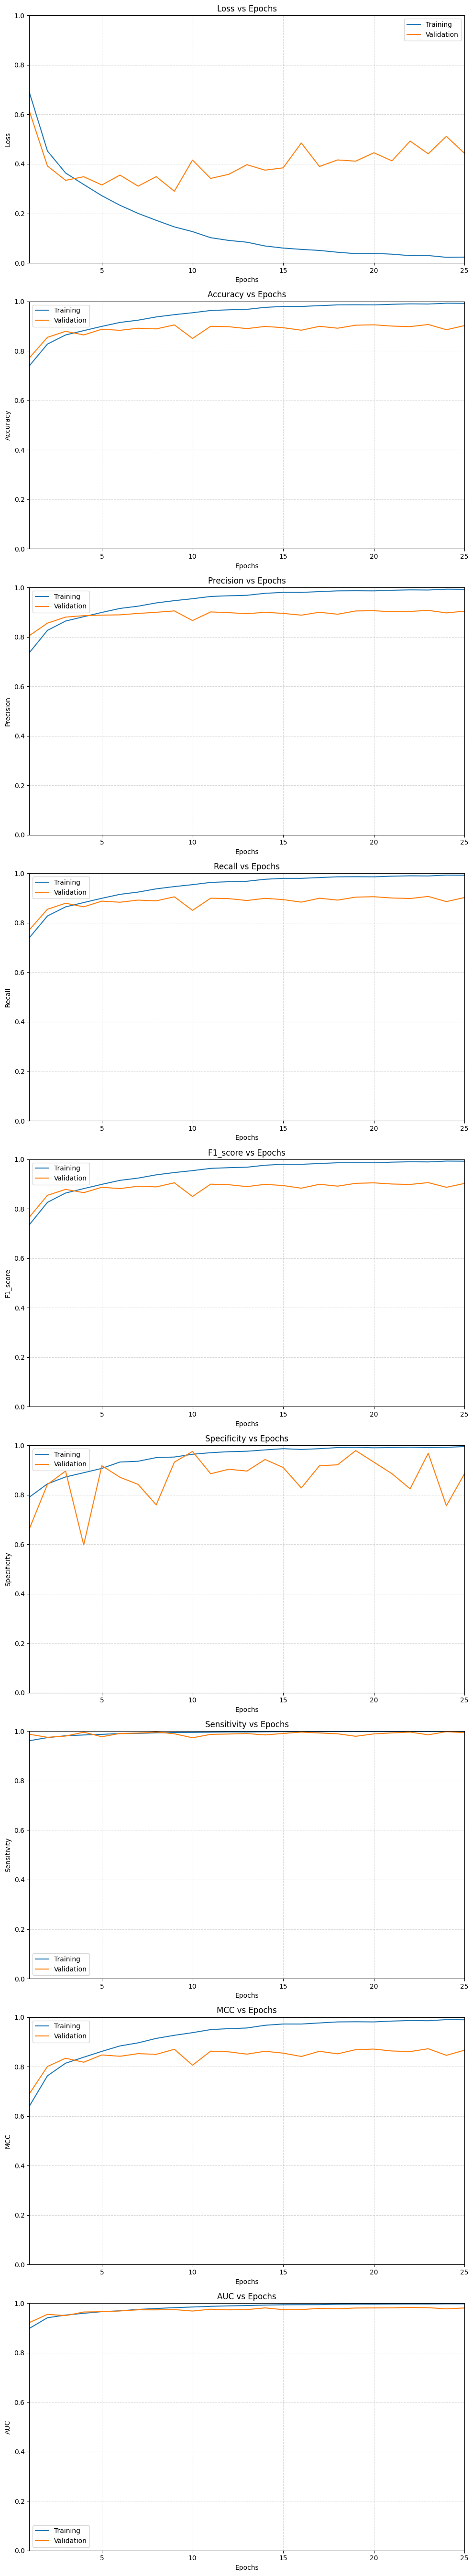

In [22]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        train_metrics_history: a dictionary containing training metrics history
        val_metrics_history: a dictionary containing validation metrics history
        metric_names: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, num_epochs + 1)

    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]

        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_name in ("auc", "mcc"):
            ax.set_ylabel(metric_name.upper())
            ax.set_title(metric_name.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_name.capitalize())
            ax.set_title(metric_name.capitalize() + " vs Epochs")

        max_metric = max(max(train_metric), max(val_metric))
        min_metric = min(min(train_metric), min(val_metric))
        y_max = math.ceil(max_metric)

        if min_metric > 0 or max_metric > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_metric, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, num_epochs)

    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)

In [23]:
model.eval()
total_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(tqdm(test_loader, desc="Testing Model")):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

average_loss = total_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

testing_metrics_line = "Metrics - "
for metric_name, metric_value in test_metrics.items():
    if metric_name == 'auc':
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}"
    else:
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}, "

print(f"{testing_metrics_line}")

Testing Model: 100%|██████████| 155/155 [00:09<00:00, 16.88it/s]

Metrics - loss: 0.4272, accuracy: 0.9059, precision: 0.9085, recall: 0.9059, f1_score: 0.9061, specificity: 0.9029, sensitivity: 0.9982, mcc: 0.8718, auc: 0.9818


In [24]:
true_labels = np.array(all_targets)

predicted_labels = np.argmax(np.array(all_predictions), axis=1)

true_labels = true_labels.astype(int)
predicted_labels = predicted_labels.astype(int)

report = classification_report(true_labels, predicted_labels, target_names=classes, digits=4)

accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)

print(report)
print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

                     precision    recall  f1-score   support

Bacterial Pneumonia     0.9843    0.9029    0.9418       278
              COVID     0.9370    0.9448    0.9409       362
       Lung_Opacity     0.8842    0.8386    0.8608       601
             Normal     0.9098    0.9205    0.9151      1019
       Tuberculosis     0.9444    0.9714    0.9577        70
    Viral Pneumonia     0.7558    0.9630    0.8469       135

           accuracy                         0.9059      2465
          macro avg     0.9026    0.9235    0.9105      2465
       weighted avg     0.9085    0.9059    0.9061      2465

There were 232 errors in 2465 tests for an accuracy of  90.59


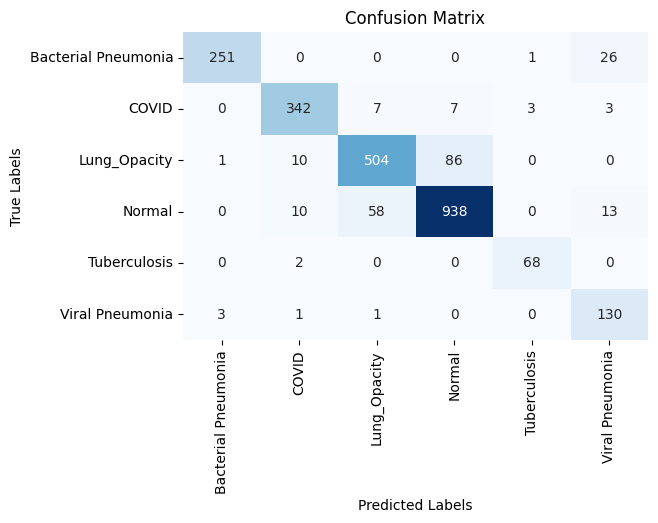

In [25]:
confusion_matrix = torch.zeros(num_classes, num_classes)
for t, p in zip(true_labels, predicted_labels):
    confusion_matrix[t, p] += 1

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()